# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://tip.duke.edu/independent_learning/greek/lesson/digging_deeper_final.jpg)



In [0]:
# In Google Colab, uncomment this:
!wget https://bit.ly/2FMJP5K -O setup.py && bash setup.py
!pip install gym==0.15.7 pyglet==1.4.10
!apt-get update && apt-get install xvfb
# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

--2020-02-23 04:29:42--  https://bit.ly/2FMJP5K
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/setup_colab.sh [following]
--2020-02-23 04:29:43--  https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/setup_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262 [text/plain]
Saving to: ‘setup.py’

setup.py            100%[===================>]     262  --.-KB/s    in 0s      

2020-02-23 04:29:43 (57.6 MB/s) - ‘setup.py’ saved [262/262]

Reading package lists... Done
Building dependency tree       
Reading state information.

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


state vector dim = 4
n_actions = 2


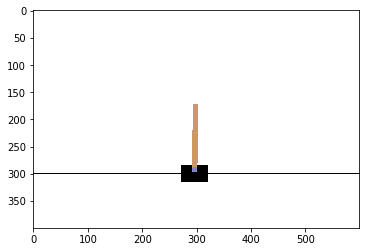

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [0]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [0]:
def generate_session(env, agent, n_actions, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(n_actions, p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [0]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, n_actions, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[ 0.03553659  0.00472503  0.00942865  0.04464812]
 [ 0.03563109 -0.19053085  0.01032162  0.3402909 ]
 [ 0.03182048 -0.38579813  0.01712743  0.63621072]
 [ 0.02410452 -0.58115471  0.02985165  0.93423783]
 [ 0.01248142 -0.77666636  0.0485364   1.23614973]]
actions: [0, 0, 0, 0, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [0]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    reward = np.percentile(rewards_batch, percentile)
    elite_states = [s for i, r in enumerate(rewards_batch) if r > reward for s in states_batch[i]]
    elite_actions = [a for i, r in enumerate(rewards_batch) if r > reward for a in actions_batch[i]]
    # <YOUR CODE: copy-paste your implementation from the previous notebook>
    
    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [0]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 228.240, threshold=268.800


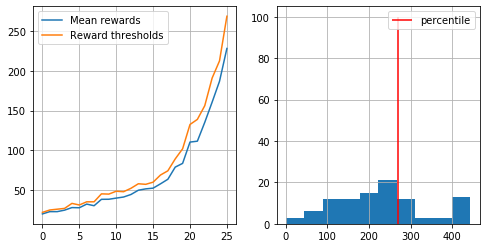

You Win! You may stop training now via KeyboardInterrupt.


In [0]:
n_sessions = 100
percentile = 70
log = []
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent, n_actions) for _ in range(n_sessions)] # < generate a list of n_sessions new sessions > ]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) # <select elite actions just like before>

    # <partial_fit agent to predict elite_actions(y) from elite_states(X)>
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

percentile = 10, iteration = 0, mean = 20.77
percentile = 10, iteration = 10, mean = 30.18
percentile = 10, iteration = 20, mean = 48.74
percentile = 10, iteration = 30, mean = 70.77
percentile = 10, iteration = 40, mean = 108.08
percentile = 10, iteration = 50, mean = 125.19
percentile = 10, iteration = 60, mean = 149.91
percentile = 10, iteration = 70, mean = 178.79
percentile = 10, iteration = 80, mean = 180.71
You Win! You may stop training now via KeyboardInterrupt.
percentile = 10, iteration = 85
percentile = 20, iteration = 0, mean = 20.1
percentile = 20, iteration = 10, mean = 24.71
percentile = 20, iteration = 20, mean = 40.02
percentile = 20, iteration = 30, mean = 62.82
percentile = 20, iteration = 40, mean = 81.8
percentile = 20, iteration = 50, mean = 116.22
percentile = 20, iteration = 60, mean = 188.37
You Win! You may stop training now via KeyboardInterrupt.
percentile = 20, iteration = 64
percentile = 30, iteration = 0, mean = 31.1
percentile = 30, iteration = 10, mean

Text(0, 0.5, 'converged at')

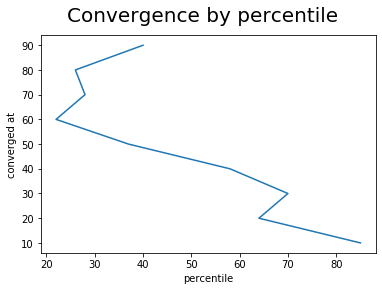

In [0]:
n_sessions = 100
percentile = 50
log = []

convergence = []
for percentile in range(10, 100, 10):
  agent = MLPClassifier(
      hidden_layer_sizes=(20, 20),
      activation='tanh',
  )

  # initialize agent to the dimension of state space and number of actions
  agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
  for i in range(100):
      # generate new sessions
      sessions = [generate_session(env, agent, n_actions) for _ in range(n_sessions)] # < generate a list of n_sessions new sessions > ]

      states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

      elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) # <select elite actions just like before>

      # <partial_fit agent to predict elite_actions(y) from elite_states(X)>
      agent.partial_fit(elite_states, elite_actions)

      # show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])
      if i % 10 == 0:
          print("percentile = {}, iteration = {}, mean = {}".format(percentile, i, np.mean(rewards_batch)))
      if np.mean(rewards_batch) > 190:
          print("You Win! You may stop training now via KeyboardInterrupt.")
          print("percentile = {}, iteration = {}".format(percentile, i))
          convergence.append(i)
          break
  else:
    convergence.append(i)

Text(0, 0.5, 'converged at')

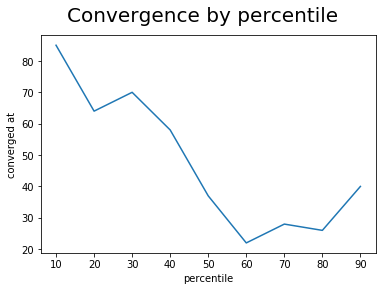

In [0]:
fig = plt.figure()
plt.plot(range(10, 100, 10), convergence)
fig.suptitle('Convergence by percentile', fontsize=20)
plt.xlabel("percentile", )
plt.ylabel("converged at")

In [0]:
n_sessions = 100
percentile = 60
log = []

convergence_by_session = []
for n_sessions in range(50, 160, 10):
  agent = MLPClassifier(
      hidden_layer_sizes=(20, 20),
      activation='tanh',
  )

  # initialize agent to the dimension of state space and number of actions
  agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
  for i in range(100):
      # generate new sessions
      sessions = [generate_session(env, agent, n_actions) for _ in range(n_sessions)] # < generate a list of n_sessions new sessions > ]

      states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

      elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) # <select elite actions just like before>

      # <partial_fit agent to predict elite_actions(y) from elite_states(X)>
      agent.partial_fit(elite_states, elite_actions)

      # show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])
      if i % 10 == 0:
          print("n_sessions = {}, iteration = {}, mean = {}".format(n_sessions, i, np.mean(rewards_batch)))
      if np.mean(rewards_batch) > 190:
          print("You Win! You may stop training now via KeyboardInterrupt.")
          print("n_sessions = {}, iteration = {}".format(n_sessions, i))
          convergence_by_session.append(i)
          break
  else:
    convergence_by_session.append(i)



n_sessions = 50, iteration = 0, mean = 21.68
n_sessions = 50, iteration = 10, mean = 35.2
n_sessions = 50, iteration = 20, mean = 47.42
n_sessions = 50, iteration = 30, mean = 70.1
n_sessions = 50, iteration = 40, mean = 123.74
You Win! You may stop training now via KeyboardInterrupt.
n_sessions = 50, iteration = 45
n_sessions = 60, iteration = 0, mean = 15.766666666666667
n_sessions = 60, iteration = 10, mean = 25.466666666666665
n_sessions = 60, iteration = 20, mean = 40.3
n_sessions = 60, iteration = 30, mean = 63.0
n_sessions = 60, iteration = 40, mean = 111.25
You Win! You may stop training now via KeyboardInterrupt.
n_sessions = 60, iteration = 46
n_sessions = 70, iteration = 0, mean = 19.67142857142857
n_sessions = 70, iteration = 10, mean = 29.87142857142857
n_sessions = 70, iteration = 20, mean = 58.457142857142856
n_sessions = 70, iteration = 30, mean = 168.71428571428572
You Win! You may stop training now via KeyboardInterrupt.
n_sessions = 70, iteration = 32
n_sessions = 80

Text(0, 0.5, 'converged at')

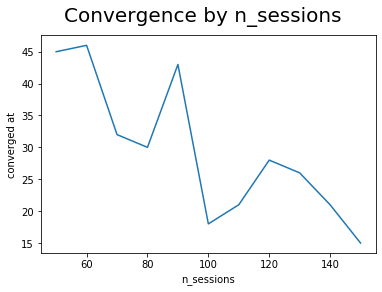

In [0]:
fig = plt.figure()
plt.plot(range(50, 160, 10), convergence_by_session)
fig.suptitle('Convergence by n_sessions', fontsize=20)
plt.xlabel("n_sessions", )
plt.ylabel("converged at")

# Results

In [0]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session(env, agent, n_actions) for _ in range(100)]
env.close()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))
print(video_names[-1])
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

openaigym.video.3.1253.video000027.mp4


# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`.
- __1.2__ (2 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


```<Describe what you did here.  Preferably with plot/report to support it.>```

Text(0, 0.5, 'converged at')

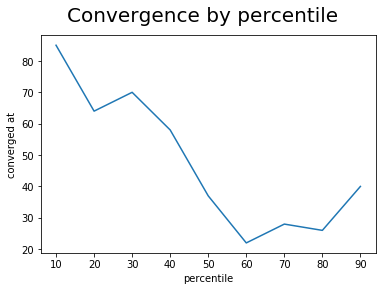

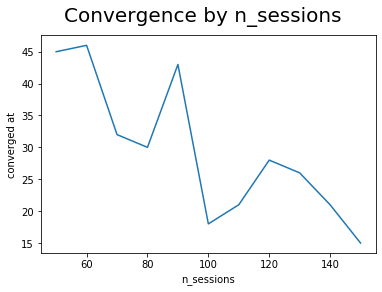

In [0]:
fig = plt.figure()
plt.plot(range(10, 100, 10), convergence)
fig.suptitle('Convergence by percentile', fontsize=20)
plt.xlabel("percentile", )
plt.ylabel("converged at")

fig = plt.figure()
plt.plot(range(50, 160, 10), convergence_by_session)
fig.suptitle('Convergence by n_sessions', fontsize=20)
plt.xlabel("n_sessions", )
plt.ylabel("converged at")

# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pt) Devise a way to speed up training against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
__Please list what you did in anytask submission form__. __It's necessary to measure your improvement experimentally__.  __You score depends on this improvement. If the algorithm converges 2x faster, you obtain 3 pts. If the algorithm converges 4x faster, you obtain 6pts__.
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


state vector dim = 2
n_actions = 3


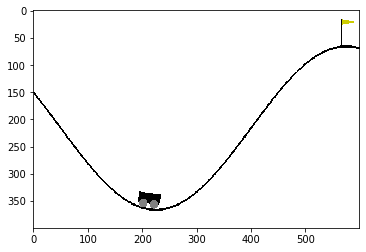

In [0]:
mountain_car_env = gym.make("MountainCar-v0").env

mountain_car_env.reset()
mc_n_actions = mountain_car_env.action_space.n
mc_state_dim = mountain_car_env.observation_space.shape[0]

plt.imshow(mountain_car_env.render("rgb_array"))
print("state vector dim =", mc_state_dim)
print("n_actions =", mc_n_actions)

# Train BaseLine

use n_session=50
don't use results from previous session
just measure execution time as a starting point

In [0]:
def train_agent_baseline(env, agent, t_max=10000, avg_reward=-150, n_sessions=150 // 3, percentile=60, gamma=1.0):
  log = []

  n_actions = env.action_space.n
  state_dim = env.observation_space.shape[0]

  # initialize agent to the dimension of state space and number of actions
  print(env.reset())
  agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

  sessions = []

  for i in range(150):
      # generate new sessions
      sessions = [generate_session(env, agent, n_actions, t_max) for _ in range(n_sessions)]

      states_batch, actions_batch, rewards_batch = map(np.array, zip(*list(sessions)))
      elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) # <select elite actions just like before>

      if len(elite_states) >= gamma * percentile * n_sessions / 100:
        agent.partial_fit(elite_states, elite_actions)
      else:
        print("len(elite_states) < limit: {}, skip training".format(len(elite_states)))

      show_progress(rewards_batch, log, percentile, reward_range=[-20000,np.max(rewards_batch)])

      if np.mean(rewards_batch) > avg_reward:
          print("You Win! You may stop training now via KeyboardInterrupt.")
          print("n_sessions = {}, iteration = {}".format(n_sessions, i))
          break
  return log

mean reward = -149.820, threshold=-141.600


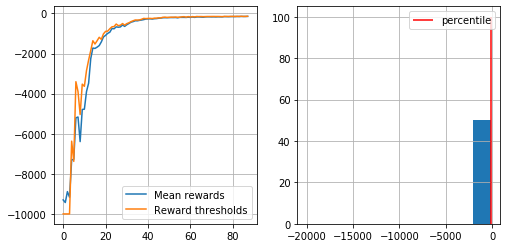

You Win! You may stop training now via KeyboardInterrupt.
n_sessions = 50, iteration = 87
1 loop, best of 1: 26min 25s per loop


In [35]:
%%timeit -r1 -n1
agent_baseline = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)


train_agent_baseline(mountain_car_env, agent_baseline, n_sessions=50, t_max=10000, avg_reward=-150)

Actually time is not fixed, sometimes it's greater (in most of the cases)

# Simple implementation which uses deque to use 2 last iterations

experiments with different t_max {1000, 2000}
for t_max less than 10000 - need to restart it multiple time, since 1 out of 10 runs will actually converge, but if it doesn't converge, it is possible to interrupt earlier after 1st iteration.

In [0]:
n_sessions = 150
percentile = 60
log = []
agent = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)
from collections import deque

def train_agent(env, agent, t_max=1000, avg_reward=190):
  log = []

  n_actions = env.action_space.n
  state_dim = env.observation_space.shape[0]

  # initialize agent to the dimension of state space and number of actions
  print(env.reset())
  agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
  sessions = deque(maxlen=3 * n_sessions)
  for i in range(100):
      # generate new sessions
      sessions.extend([generate_session(env, agent, n_actions, t_max) for _ in range(n_sessions)]) # < generate a list of n_sessions new sessions > ]
      states_batch, actions_batch, rewards_batch = map(np.array, zip(*list(sessions)))


      elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) # <select elite actions just like before>

      if len(elite_states) > 0.5 * percentile * n_sessions / 100:
        agent.partial_fit(elite_states, elite_actions)
      else:
        print("len(elite_states) < limit: {}, skip training".format(len(elite_states))) 

      show_progress(rewards_batch, log, percentile, reward_range=[-20000,np.max(rewards_batch)])

      if np.mean(rewards_batch) > avg_reward:
          print("You Win! You may stop training now via KeyboardInterrupt.")
          print("n_sessions = {}, iteration = {}".format(n_sessions, i))
          break
  return log

mean reward = -149.967, threshold=-146.000


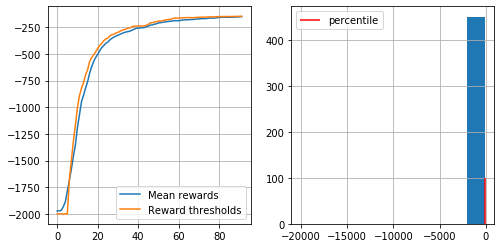

You Win! You may stop training now via KeyboardInterrupt.
n_sessions = 150, iteration = 91
1 loop, best of 1: 27min 50s per loop


In [0]:
%%timeit -r1 -n1

log = []
agent = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)


log = train_agent(mountain_car_env, agent, t_max=2000, avg_reward=-150)

mean reward = -157.771, threshold=-139.600


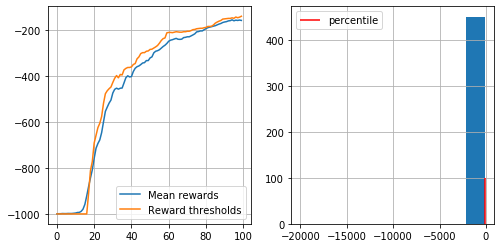

1 loop, best of 1: 29min 54s per loop


In [0]:
%%timeit -r1 -n1

log = []
agent = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)


log = train_agent(mountain_car_env, agent, t_max=1000, avg_reward=-150)

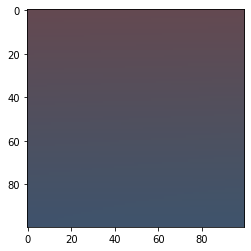

In [0]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs

plt.imshow(visualize_mountain_car(mountain_car_env, agent))

# More experiments with MountainCar, try to use different threshold as gamma for training or skipping training depending on number of good sessions available

In [0]:
def train_agent_v2(env, agent, t_max=10000, avg_reward=190, n_sessions=150 // 3, percentile=60, gamma=1.0):
  log = []

  n_actions = env.action_space.n
  state_dim = env.observation_space.shape[0]

  # initialize agent to the dimension of state space and number of actions
  agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
  sessions = deque(maxlen=3 * n_sessions)
  for i in range(150):
      # generate new sessions
      sessions.extend([generate_session(env, agent, n_actions, t_max) for _ in range(n_sessions)]) # < generate a list of n_sessions new sessions > ]
      states_batch, actions_batch, rewards_batch = map(np.array, zip(*list(sessions)))

      elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) # <select elite actions just like before>

      if len(elite_states) >= gamma * percentile * n_sessions / 100:
        agent.partial_fit(elite_states, elite_actions)
      else:
        print("len(elite_states) < limit: {}, skip training".format(len(elite_states)))

      show_progress(rewards_batch, log, percentile, reward_range=[-20000,np.max(rewards_batch)])

      if np.mean(rewards_batch) > avg_reward:
          print("You Win!, n_sessions = {}, iteration = {}".format(n_sessions, i))
          break
  return log

mean reward = -156.553, threshold=-145.000


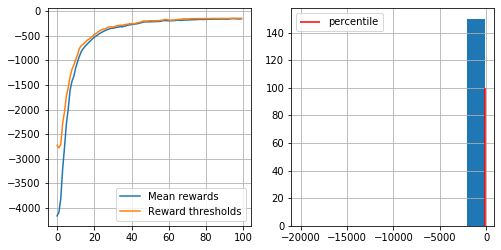

1 loop, best of 1: 12min 10s per loop


In [0]:
%%timeit -r1 -n1
log = []
agent_v2 = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)


train_agent_v2(mountain_car_env, agent_v2, avg_reward=-150)

It seems I was extremelly lucky for this run. Usually, it takes more time, but lets keep it for history


mean reward = -149.949, threshold=-144.000


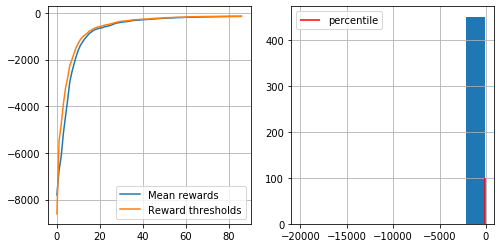

You Win! You may stop training now via KeyboardInterrupt.
n_sessions = 150, iteration = 86
1 loop, best of 1: 44min 1s per loop


In [0]:
%%timeit -r1 -n1
log = []
agent_v3 = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)


train_agent_v2(mountain_car_env, agent_v3, n_sessions=150, t_max=10000, avg_reward=-150, gamma=0.5)

# Increase n_sessions but keep sessions history size constant, thus we use less and less items from previous sessions when n_sessions grows

In [0]:
def train_agent_v3(env, agent, t_max=10000, avg_reward=-150, n_sessions=150 // 3, percentile=60, gamma=1.0):
  log = []

  n_actions = env.action_space.n
  state_dim = env.observation_space.shape[0]

  # initialize agent to the dimension of state space and number of actions
  print(env.reset())
  agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
  max_size = 3 * n_sessions
  sessions = deque(maxlen=max_size)
  best_mean = -t_max
  for i in range(150):
      # generate new sessions
      sessions.extend([generate_session(env, agent, n_actions, t_max) for _ in range(n_sessions)]) # < generate a list of n_sessions new sessions > ]
      states_batch, actions_batch, rewards_batch = map(np.array, zip(*list(sessions)))


      elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) # <select elite actions just like before>
      if len(elite_states) >= gamma * percentile * n_sessions / 100:
        agent.partial_fit(elite_states, elite_actions)
      else:
        print("len(elite_states) < limit: {}, skip training".format(len(elite_states)))

      # show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])
      show_progress(rewards_batch, log, percentile, reward_range=[-20000,np.max(rewards_batch)])
      if np.mean(rewards_batch) > best_mean / 3:
          n_sessions = min(2 * n_sessions, max_size)
          best_mean //= 3

      if np.mean(rewards_batch) > avg_reward:
          print("n_sessions = {}, iteration = {}".format(n_sessions, i))
          break
  return log

mean reward = -148.427, threshold=-123.000


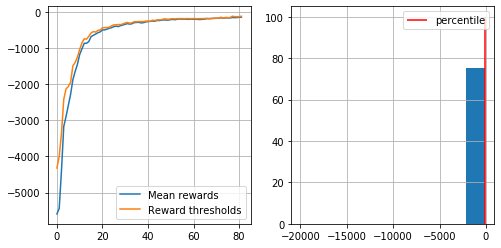

You Win! You may stop training now via KeyboardInterrupt.
n_sessions = 75, iteration = 81
1 loop, best of 1: 17min 25s per loop


In [0]:
%%timeit -r1 -n1
log = []
agent_v4 = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)


train_agent_v3(mountain_car_env, agent_v4, n_sessions=25, t_max=10000, avg_reward=-150, gamma=1.0)

# Increase n_sessions and extend sessions history to keep history from 2 runs

In [0]:
def train_agent_v4(env, agent, t_max=10000, avg_reward=-150, n_sessions=150 // 3, percentile=60, gamma=1.0):
  log = []

  n_actions = env.action_space.n
  state_dim = env.observation_space.shape[0]

  # initialize agent to the dimension of state space and number of actions
  print(env.reset())
  agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
  max_size = 3 * n_sessions
  sessions = deque(maxlen=max_size)
  best_mean = -t_max
  for i in range(150):
      # generate new sessions
      sessions.extend([generate_session(env, agent, n_actions, t_max) for _ in range(n_sessions)]) # < generate a list of n_sessions new sessions > ]

      states_batch, actions_batch, rewards_batch = map(np.array, zip(*list(sessions)))

      elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) # <select elite actions just like before>

      if len(elite_states) >= gamma * percentile * n_sessions / 100:
        agent.partial_fit(elite_states, elite_actions)
      else:
        print("len(elite_states) < limit: {}, skip training".format(len(elite_states)))


      show_progress(rewards_batch, log, percentile, reward_range=[-11000,np.max(rewards_batch)])
      if np.mean(rewards_batch) > (best_mean / 3):
          print("update n_sessions and best_mean {} {} {}".format(n_sessions,
                                                                  best_mean,
                                                                  np.mean(rewards_batch)
                                                                    ))
          n_sessions = min(max_size, int(1.5 * n_sessions))
          best_mean = np.mean(rewards_batch)
          sessions = deque(sessions, maxlen=3 * n_sessions)

      if np.mean(rewards_batch) > avg_reward:
          print("You Win! n_sessions = {}, iteration = {}".format(n_sessions, i))
          break
  return log

mean reward = -148.973, threshold=-139.000


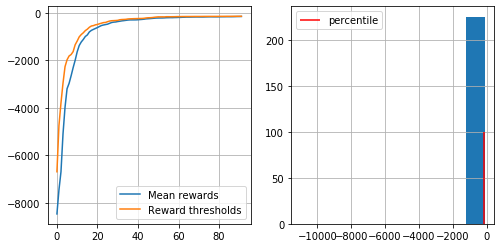

You Win! n_sessions = 75, iteration = 91
1 loop, best of 1: 12min 15s per loop


In [41]:
%%timeit -r1 -n1
agent_v5 = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)


train_agent_v4(mountain_car_env, agent_v5, n_sessions=25, percentile=75, t_max=10000, avg_reward=-150, gamma=1.0)

# Parallelized version

Take the fastest version from previous runs and try to parallelilize it.

In [0]:
from joblib import Parallel, delayed


agent_v2 = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)

def parallel_generate_session(n_actions, t_max):
    states, actions = [], []
    total_reward = 0

    s = mountain_car_env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent_v2.predict_proba([s])[0]

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(n_actions, p=probs)

        new_s, r, done, info = mountain_car_env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

def parallel_generate(n_actions, t_max, n_sessions , n_jobs = 3) :
    sess = Parallel(n_jobs = n_jobs , backend = 'multiprocessing')(
        delayed(parallel_generate_session)(n_actions, t_max) for _ in range(n_sessions) )
    return sess


def train_agent_parallel(env, agent, t_max=10000, avg_reward=190, n_sessions=150 // 3, percentile=60, gamma=1.0):
  log = []

  n_actions = env.action_space.n
  state_dim = env.observation_space.shape[0]

  # initialize agent to the dimension of state space and number of actions
  agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
  sessions = deque(maxlen=3 * n_sessions)
  for i in range(150):
      # generate new sessions
      sessions.extend(parallel_generate(n_actions, t_max, n_sessions))

      states_batch, actions_batch, rewards_batch = map(np.array, zip(*list(sessions)))

      elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) # <select elite actions just like before>

      # <partial_fit agent to predict elite_actions(y) from elite_states(X)>
      if len(elite_states) >= gamma * percentile * n_sessions / 100:
        agent.partial_fit(elite_states, elite_actions)
      else:
        print("len(elite_states) < limit: {}, skip training".format(len(elite_states)))

      show_progress(rewards_batch, log, percentile, reward_range=[-20000,np.max(rewards_batch)])

      if np.mean(rewards_batch) > avg_reward:
          print("You Win! n_sessions = {}, iteration = {}".format(n_sessions, i))
          break
  return log

mean reward = -149.507, threshold=-143.000


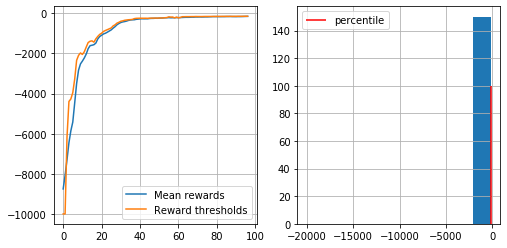

You Win! n_sessions = 50, iteration = 96
1 loop, best of 1: 18min 29s per loop


In [30]:
%%timeit -r1 -n1
train_agent_parallel(mountain_car_env, agent_v2, avg_reward=-150)

In [33]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits 

In [0]:
agent_v2 = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)

def parallel_generate_session(n_actions, t_max):
    states, actions = [], []
    total_reward = 0

    s = mountain_car_env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent_v2.predict_proba([s])[0]

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(n_actions, p=probs)

        new_s, r, done, info = mountain_car_env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

def parallel_generate(n_actions, t_max, n_sessions , n_jobs = 3) :
    sess = Parallel(n_jobs = n_jobs , backend = 'multiprocessing')(
        delayed(parallel_generate_session)(n_actions, t_max) for _ in range(n_sessions) )
    return sess

def train_agent_parallel_v2(env, agent, t_max=10000, avg_reward=-150, n_sessions=150 // 3, percentile=60, gamma=1.0):
  log = []

  n_actions = env.action_space.n
  state_dim = env.observation_space.shape[0]

  # initialize agent to the dimension of state space and number of actions
  print(env.reset())
  agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
  max_size = 3 * n_sessions
  sessions = deque(maxlen=max_size)
  best_mean = -t_max
  for i in range(150):
      # generate new sessions
      # sessions.extend([generate_session(env, agent, n_actions, t_max) for _ in range(n_sessions)]) # < generate a list of n_sessions new sessions > ]
      sessions.extend(parallel_generate(n_actions, t_max, n_sessions))

      states_batch, actions_batch, rewards_batch = map(np.array, zip(*list(sessions)))

      elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) # <select elite actions just like before>

      if len(elite_states) >= gamma * percentile * n_sessions / 100:
        agent.partial_fit(elite_states, elite_actions)
      else:
        print("len(elite_states) < limit: {}, skip training".format(len(elite_states)))


      show_progress(rewards_batch, log, percentile, reward_range=[-11000,np.max(rewards_batch)])
      if np.mean(rewards_batch) > (best_mean / 3):
          print("update n_sessions and best_mean {} {} {}".format(n_sessions,
                                                                  best_mean,
                                                                  np.mean(rewards_batch)
                                                                    ))
          n_sessions = min(max_size, int(1.5 * n_sessions))
          best_mean = np.mean(rewards_batch)
          sessions = deque(sessions, maxlen=3 * n_sessions)

      if np.mean(rewards_batch) > avg_reward:
          print("You Win! n_sessions = {}, iteration = {}".format(n_sessions, i))
          break
  return log

mean reward = -149.884, threshold=-122.000


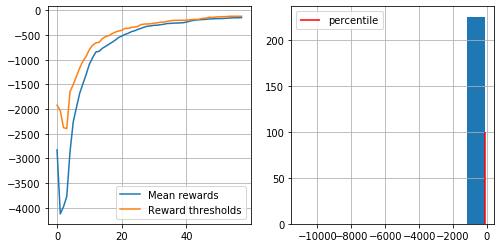

You Win! n_sessions = 75, iteration = 57
1 loop, best of 1: 7min 44s per loop


In [56]:
%%timeit -r1 -n1
train_agent_parallel_v2(mountain_car_env, agent_v2, n_sessions=25, percentile=75, avg_reward=-150)

It converged in 7min 44s which is almost 4 times faster than baseline, but still, I feel some randomness because even baseline sometimes does not converge at all and I can run it multiple times and choose the slowest one (and it might be 40minutes or even more). Results are not stable that is my major concern.

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.


If you're still feeling unchallenged, consider the project (see other notebook in this folder).